# Precipitation Forecasting using XGBoost

In this notebook, we investigate XGBoost (eXtreme Gradient Boosting) as a model to forecast precipitation. XGBoost is an efficient implementation of gradient boosting machines that builds an ensemble of decision trees sequentially. Each tree tries to correct the errors made by the previous trees. Unlike RNNs which maintain internal states, XGBoost treats our time series data as a traditional supervised learning problem where we flatten the temporal sequences into feature vectors.

## 0. Imports and Basic Setup

In [1]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

## 1. Load Preprocessed Train, Validation, and Test Splits


In [ ]:
train_data = pd.read_csv("../data/processed/train_data.csv")
validation_data = pd.read_csv("../data/processed/validation_data.csv")
test_data = pd.read_csv("../data/processed/test_data.csv")

# Sort splits by location -> YYYY -> DOY to ensure correct time ordering
train_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
validation_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)
test_data.sort_values(by=["location", "YYYY", "DOY"], inplace=True)

First 50 rows of train data:
       location  YYYY  DOY   MM    DD  2m_temp_max  2m_temp_mean  2m_temp_min  \
421855   ID_102  1981    1  1.0   1.0    -1.102070     -1.170794    -1.460009   
421856   ID_102  1981    2  1.0   2.0    -1.212777     -0.914359    -0.606222   
421857   ID_102  1981    3  1.0   3.0    -0.670313     -0.459770    -0.341668   
421858   ID_102  1981    4  1.0   4.0    -0.747808     -0.669580    -0.449895   
421859   ID_102  1981    5  1.0   5.0    -1.434190     -1.240731    -0.882801   
421860   ID_102  1981    6  1.0   6.0    -1.633463     -1.345636    -0.991027   
421861   ID_102  1981    7  1.0   7.0    -1.821664     -1.683664    -1.484059   
421862   ID_102  1981    8  1.0   8.0    -2.264492     -2.045005    -2.217594   
421863   ID_102  1981    9  1.0   9.0    -1.810594     -2.406345    -2.650500   
421864   ID_102  1981   10  1.0  10.0    -1.312413     -1.788569    -2.205569   
421865   ID_102  1981   11  1.0  11.0    -1.522756     -1.438885    -1.279631   

## 2. Create Sequences for XGBoost


In [7]:
def create_sequences(df, feature_cols, target_col, seq_length=30):
    """
    Create sequences for time series prediction, grouped by location.
    Unlike RNNs which keep the temporal dimension, we flatten the sequences
    for XGBoost into a single feature vector.
    
    Parameters:
    df (pandas.DataFrame): DataFrame with time series data
    feature_cols (list): List of feature column names
    target_col (str): Name of the target column
    seq_length (int): Length of sequence to use for prediction
    
    Returns:
    tuple: (X array of shape (n_samples, seq_length * n_features),
            y array of shape (n_samples,))
    """
    X_list, y_list = [], []
    grouped = df.groupby("location", group_keys=True)
    
    for loc, loc_df in grouped:
        loc_df = loc_df.reset_index(drop=True)
        loc_features = loc_df[feature_cols].values
        loc_target = loc_df[target_col].values
        
        for i in range(len(loc_df) - seq_length):
            # Flatten the sequence into a single feature vector
            sequence = loc_features[i:i + seq_length].flatten()
            X_list.append(sequence)
            y_list.append(loc_target[i + seq_length])
    
    return np.array(X_list), np.array(y_list)

## 3. Define Features and Target


In [5]:
exclude_cols = ["location", "YYYY", "DOY", "MM", "DD"]
feature_cols = [col for col in train_data.columns if col not in exclude_cols]
target_col = "prec"

print("Feature columns:", feature_cols)
print("Target column:", target_col)

Feature columns: ['2m_temp_max', '2m_temp_mean', '2m_temp_min', '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u', '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe', 'surf_net_solar_rad_max', 'surf_net_solar_rad_mean', 'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press', 'total_et', 'prec', 'volsw_123', 'volsw_4']
Target column: prec


## 4. Generate sequences

In [6]:
SEQ_LENGTH = 30
X_train, y_train = create_sequences(train_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_val, y_val = create_sequences(validation_data, feature_cols, target_col, seq_length=SEQ_LENGTH)
X_test, y_test = create_sequences(test_data, feature_cols, target_col, seq_length=SEQ_LENGTH)

print("Train sequence shape:", X_train.shape, y_train.shape)
print("Validation sequence shape:", X_val.shape, y_val.shape)
print("Test sequence shape:", X_test.shape, y_test.shape)

Train sequence shape: (1202420, 630) (1202420,)
Validation sequence shape: (106720, 630) (106720,)
Test sequence shape: (106620, 630) (106620,)


##  5. Build and Train XGBoost Model


In [8]:
# Create feature names for interpretation
feature_names = [f"{col}_t{i}" for i in range(SEQ_LENGTH) for col in feature_cols]

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=feature_names)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=feature_names)

# Set XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # regression task
    'eval_metric': ['rmse', 'mae'],   # metrics to evaluate
    'max_depth': 6,                   # maximum depth of trees
    'learning_rate': 0.01,            # learning rate
    'subsample': 0.8,                 # fraction of samples used for tree building
    'colsample_bytree': 0.8,          # fraction of features used for tree building
    'min_child_weight': 1,            # minimum sum of instance weight in a child
}

# Train model with early stopping
model = xgb.train(
    params,
    dtrain,
    num_boost_round=1000,
    evals=[(dtrain, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=100
)

[0]	train-rmse:0.99841	train-mae:0.66543	val-rmse:1.02085	val-mae:0.67715
[100]	train-rmse:0.90764	train-mae:0.58488	val-rmse:0.93824	val-mae:0.60424
[200]	train-rmse:0.88102	train-mae:0.55788	val-rmse:0.91840	val-mae:0.58159
[300]	train-rmse:0.86802	train-mae:0.54556	val-rmse:0.91203	val-mae:0.57262
[400]	train-rmse:0.85878	train-mae:0.53861	val-rmse:0.90932	val-mae:0.56875
[500]	train-rmse:0.85154	train-mae:0.53426	val-rmse:0.90787	val-mae:0.56698
[600]	train-rmse:0.84540	train-mae:0.53090	val-rmse:0.90728	val-mae:0.56623
[700]	train-rmse:0.84001	train-mae:0.52791	val-rmse:0.90686	val-mae:0.56571
[800]	train-rmse:0.83487	train-mae:0.52519	val-rmse:0.90657	val-mae:0.56538
[900]	train-rmse:0.83011	train-mae:0.52260	val-rmse:0.90619	val-mae:0.56509
[999]	train-rmse:0.82582	train-mae:0.52027	val-rmse:0.90581	val-mae:0.56474


## 6. Evaluate the Model

In [9]:
# Make predictions
val_preds = model.predict(dval)
test_preds = model.predict(dtest)

# Calculate metrics for validation set
val_mse = mean_squared_error(y_val, val_preds)
val_rmse = np.sqrt(val_mse)
val_mae = mean_absolute_error(y_val, val_preds)

print(f"Validation MSE:  {val_mse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation MAE:  {val_mae:.4f}")

# Calculate metrics for test set
test_mse = mean_squared_error(y_test, test_preds)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, test_preds)

print(f"\nTest MSE:  {test_mse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE:  {test_mae:.4f}")

Validation MSE:  0.8205
Validation RMSE: 0.9058
Validation MAE:  0.5647

Test MSE:  0.7956
Test RMSE: 0.8920
Test MAE:  0.5685


## 7. Visualize Predictions

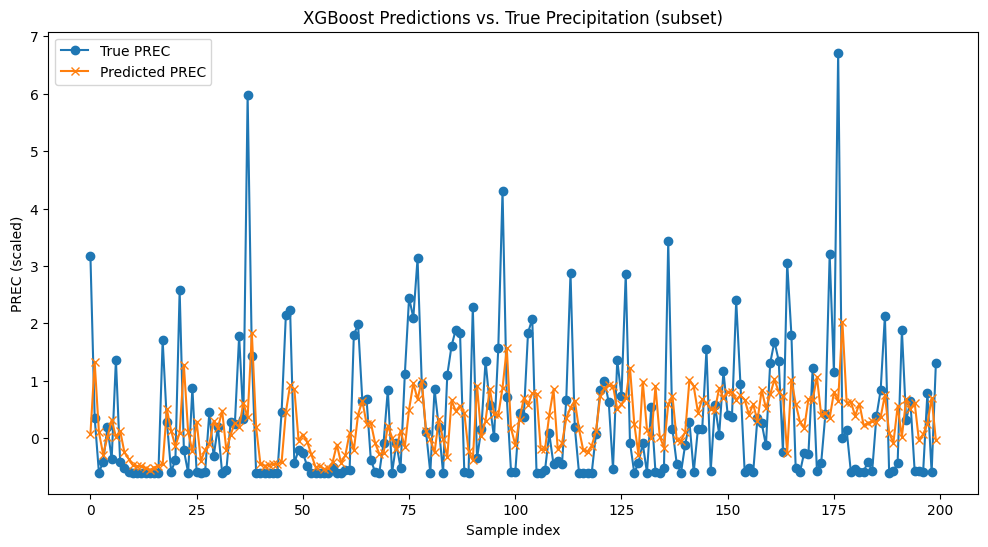

In [10]:
num_samples_to_plot = 200
plt.figure(figsize=(12,6))
plt.plot(y_test[:num_samples_to_plot], label='True PREC', marker='o')
plt.plot(test_preds[:num_samples_to_plot], label='Predicted PREC', marker='x')
plt.title("XGBoost Predictions vs. True Precipitation (subset)")
plt.xlabel("Sample index")
plt.ylabel("PREC (scaled)")
plt.legend()
plt.show()

## 8. Feature Importance Study


To investigate feature importance in XGBoost models, we measure the gain of certain variables. The gain in XGBoost measures the average improvement in the loss function (e.g., RMSE) achieved by splits using a specific feature across all trees. A higher gain indicates that the feature contributes more significantly to reducing prediction error.  

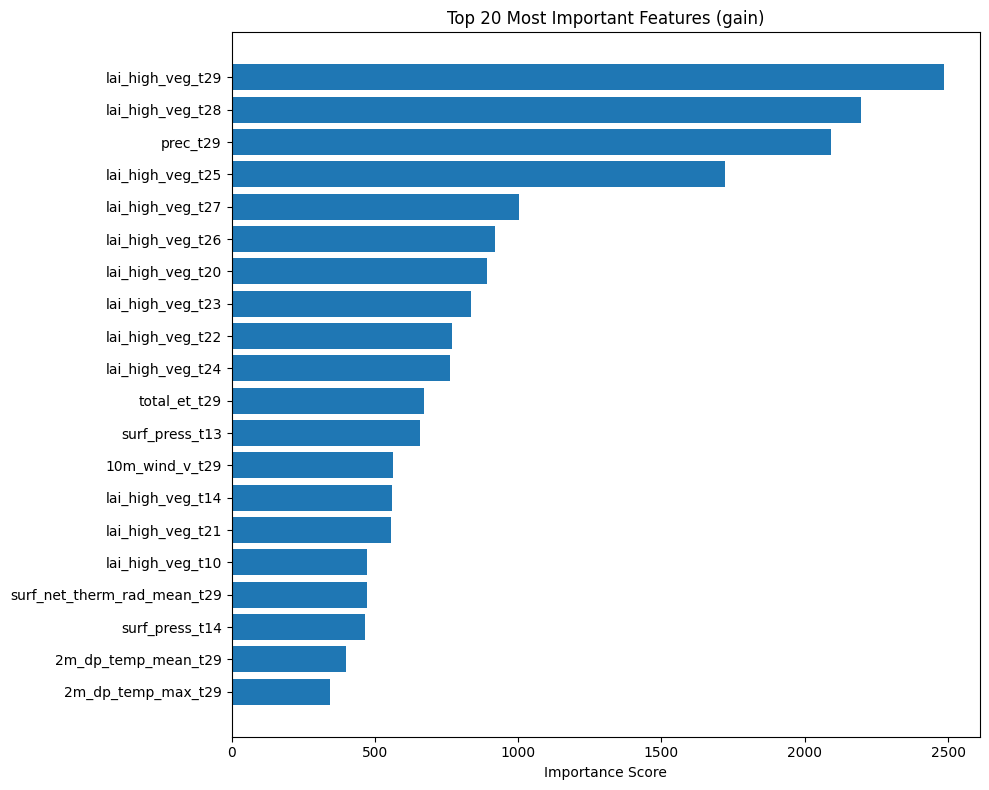

In [11]:
# Get feature importance scores
importance_scores = model.get_score(importance_type='gain')
importance_df = pd.DataFrame(
    [(k, v) for k, v in importance_scores.items()],
    columns=['Feature', 'Importance']
).sort_values('Importance', ascending=True)

# Plot feature importance
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'].tail(20), importance_df['Importance'].tail(20))
plt.title('Top 20 Most Important Features (gain)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


## 9. Analyze Temporal Importance


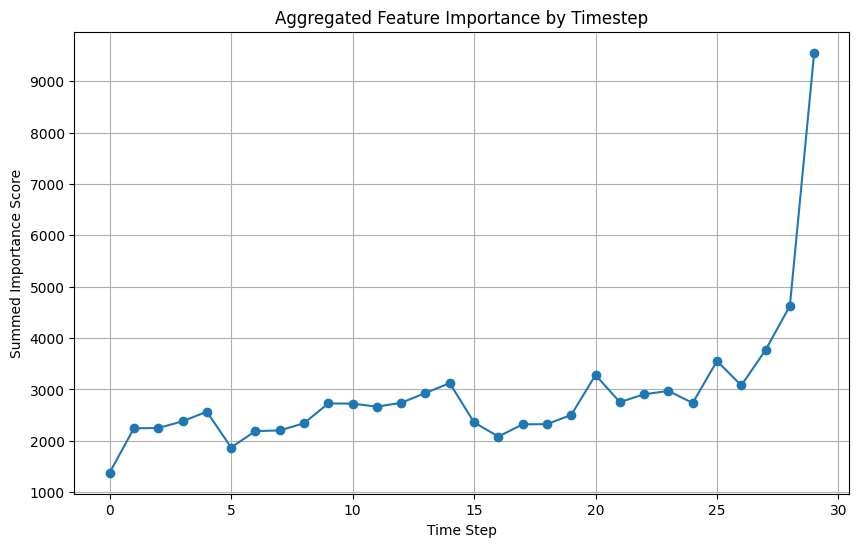

: 

In [ ]:
# Extract timesteps from feature names and aggregate importance by time
def extract_timestep(feature_name):
    return int(feature_name.split('_t')[-1])

importance_df['timestep'] = importance_df['Feature'].apply(extract_timestep)
temporal_importance = importance_df.groupby('timestep')['Importance'].sum().reset_index()

plt.figure(figsize=(10, 6))
plt.plot(temporal_importance['timestep'], temporal_importance['Importance'], marker='o')
plt.title('Aggregated Feature Importance by Timestep')
plt.xlabel('Time Step')
plt.ylabel('Summed Importance Score')
plt.grid(True)
plt.show()

Here, we can see that, as one would expect, the later time steps are much more important than the earlier ones